# Heart Failure Prediction Project - ML **Steps**

1. **Define the goal** — Predict `DEATH_EVENT` (1 = death, 0 = alive)

2. **Load the data** — Use `pandas` to read the dataset

3. **Explore the data** — Check `.head()`, `.info()`, `.describe()`

4. **Clean the data** — Handle missing values, data types, outliers

5. **EDA (Exploratory Data Analysis)** — Visualize distributions, correlations, and feature vs target relationships

6. **Preprocess the data** — 
   - Split into features (X) and target (y)  
   - Train/test split  
   - Normalize/scale (if needed)  
   - Handle class imbalance (optional)

7. **Train models** — Try multiple classifiers:
   - Logistic Regression  
   - Decision Tree  
   - Random Forest  
   - KNN  
   - XGBoost
   - Naive Bayes
   - Support Vector Machine (SVM)
   - LightGBM / CatBoost


8. **Evaluate models** — Use metrics like:
   - Accuracy, Precision, Recall, F1-score  
   - Confusion matrix  
   - ROC curve (optional)

9. **Analyze feature importance** — With tree models or SHAP (optional)

10. **Save the model** — Use `pickle` or `joblib`

11. **Summarize results** — Best model, key features, improvements

12. **(Optional)** — Build a dashboard, upload to GitHub, enhance further


In [57]:
# age: Patient's age in years  
# Normal adult range: ~18 to 100+  
# Older age is a risk factor for death in heart failure patients.

# anaemia: Indicates if the patient has anemia (low red blood cell count)  
# 1 = Yes, 0 = No  
# Anemia can worsen outcomes in heart failure due to less oxygen delivery.

# creatinine_phosphokinase (CPK): Level of the CPK enzyme released during muscle damage (especially heart)  
# Unit: U/L  
# Normal range: ~10 to 120 U/L  
# Very high levels (e.g., >1000) may indicate serious muscle injury or heart attack.

# diabetes: Whether the patient has diabetes mellitus  
# 1 = Yes, 0 = No  
# Diabetes increases cardiovascular risk and mortality.

# ejection_fraction: Percentage of blood ejected from the heart in each beat  
# Unit: %  
# Normal range: 55% to 70%  
# Values <40% indicate reduced heart function, a key heart failure marker.

# high_blood_pressure: Indicates if the patient has hypertension  
# 1 = Yes, 0 = No  
# High blood pressure strains the heart and increases risk of complications.

# platelets: Number of platelets in the blood  
# Unit: kiloplatelets/mL  
# Normal range: 150,000 to 400,000  
# Abnormal values may indicate bleeding/clotting issues or inflammation.

# serum_creatinine: Level of creatinine in the blood, a marker of kidney function  
# Unit: mg/dL  
# Normal range: ~0.6 to 1.3 mg/dL  
# High values suggest kidney dysfunction, which is a risk factor in heart failure.

# serum_sodium: Sodium concentration in the blood  
# Unit: mEq/L  
# Normal range: 135 to 145  
# Low sodium (hyponatremia) is common in heart failure and linked to poor outcomes.

# sex: Gender of the patient  
# 1 = Male, 0 = Female  
# Used to check for gender-based differences in outcomes.

# smoking: Indicates if the patient smokes  
# 1 = Yes, 0 = No  
# Smoking is a major cardiovascular risk factor.

# time: Duration (in days) of follow-up period  
# Indicates how long each patient was monitored  
# Important in survival analysis (higher time + alive = better outcome).

# DEATH_EVENT: Target variable – whether the patient died during the follow-up period  
# 1 = Death, 0 = Alive  
# Goal is to predict this using the other features.


## 1. Import Libraries

In [58]:
# -----------------------------
# Basic Libraries
# -----------------------------
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# Visualization
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# -----------------------------
# Preprocessing
# -----------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import norm, skew,boxcox
# -----------------------------
# Modeling
# -----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.pipeline import Pipeline

# -----------------------------
# Evaluation Metrics
# -----------------------------
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

# -----------------------------
# Model Saving
# -----------------------------
import pickle
import joblib


from lightgbm import early_stopping
from sklearn.model_selection import StratifiedKFold, cross_val_score


## 2. Load and Explore the Data

In [59]:
df = pd.read_csv(r'raw_data/heart_failure_clinical_records_dataset.csv')

In [60]:
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [62]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [63]:
df.duplicated().sum()

np.int64(0)

In [64]:
df.describe()

age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.000000  212500.000000   
50%            38.000000             0.000000  262000.000000   
75%            45.000000             1.000000  303500.000000   
max            80.000000             1.000000  850000.000000   

       serum_creatinine  serum_sodium         sex    smoking        time  \
count         299.00000    299.000000  299.000000  299.00000  299.000000   
mean            1.39388    136.625418    0.648829    0.32107  130.260870   
std             1.03451      4.412477    0.478136    0.46767   77.614208   
min             0.50000    113.000000    0.000000    0.00000    4.000000   
25%             0.90000    134.000000    0.000000    0.00000   73.000000   
50%             1.10000    137.000000    1.000000    0.00000  115.000000   
75%             1.40000    140.000000    1.000000    1.00000  203.000000   
max             9.40000    148.000000    1.000000    1.00000  285.000000   

       DEATH_EVENT  
count    299.00000  
mean       0.32107  
std        0.46767  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        1.00000  
max        1.00000

In [65]:
df['DEATH_EVENT'].value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

## 3.  EDA

In [66]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

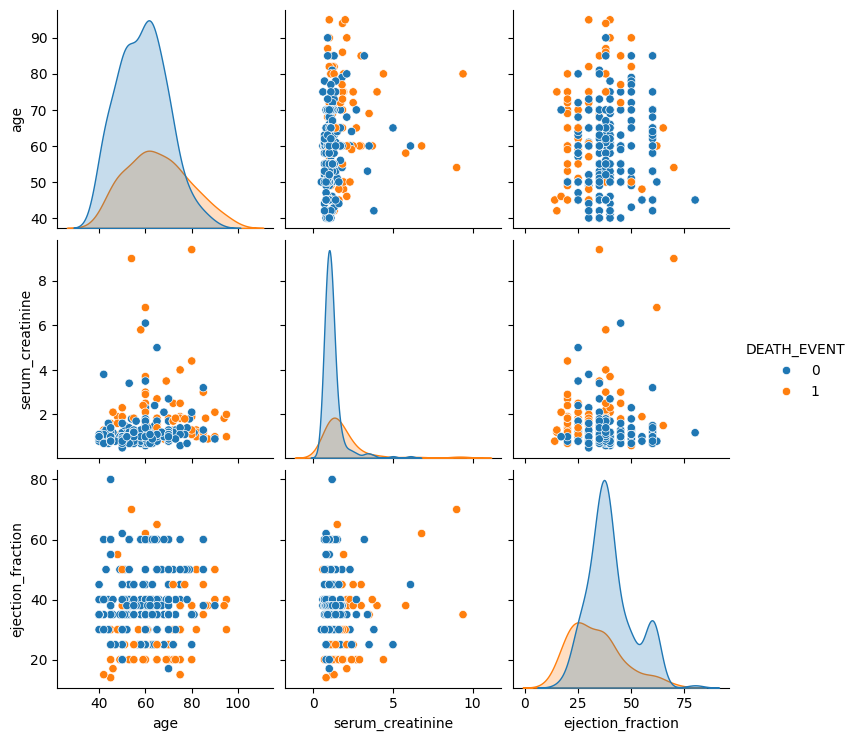

In [67]:
sns.pairplot(df[['age', 'serum_creatinine', 'ejection_fraction', 'DEATH_EVENT']],hue='DEATH_EVENT')


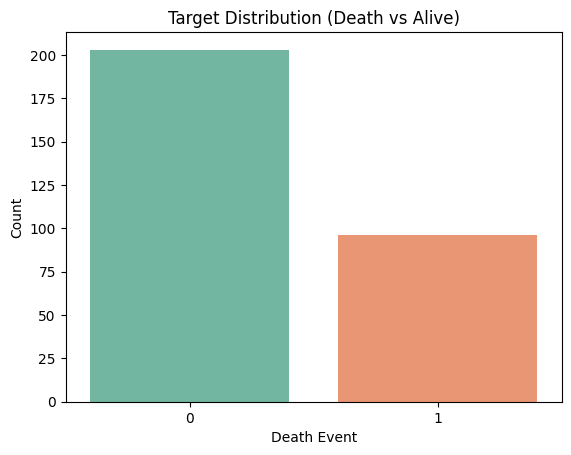

In [68]:
# Distribution of Target (DEATH_EVENT)
sns.countplot(x='DEATH_EVENT' , data=df , palette='Set2')
plt.title("Target Distribution (Death vs Alive)")
plt.xlabel("Death Event")
plt.ylabel("Count")
plt.show()

In [69]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

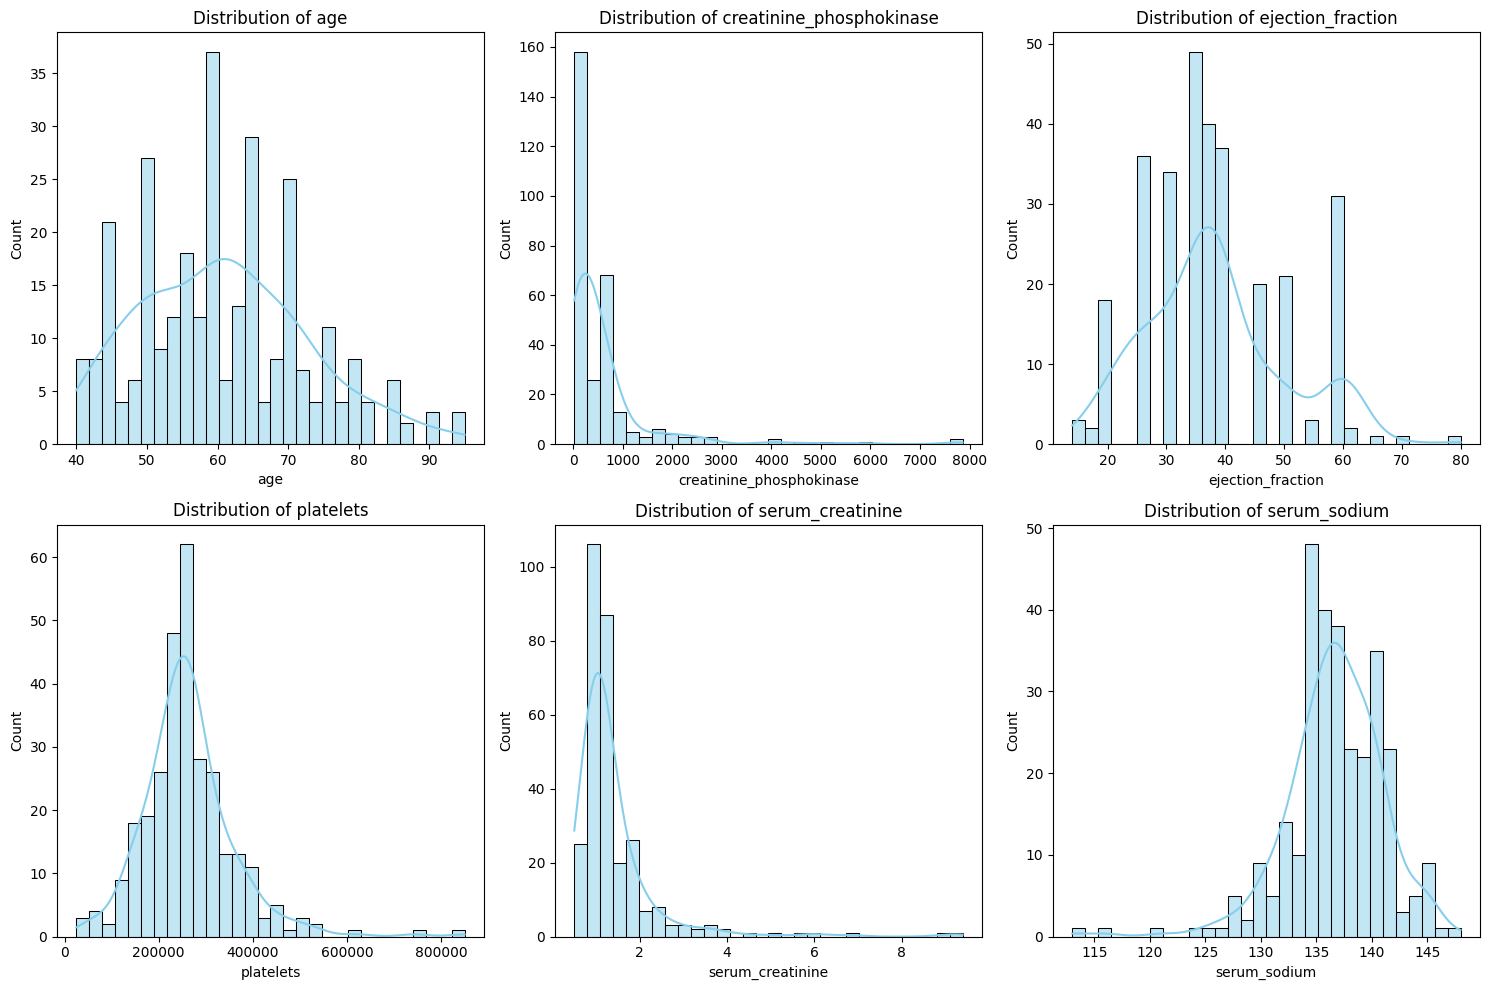

In [70]:
# Distribution Plots for Numerical Features
numeric = ['age', 'creatinine_phosphokinase',
       'ejection_fraction','platelets',
       'serum_creatinine', 'serum_sodium']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

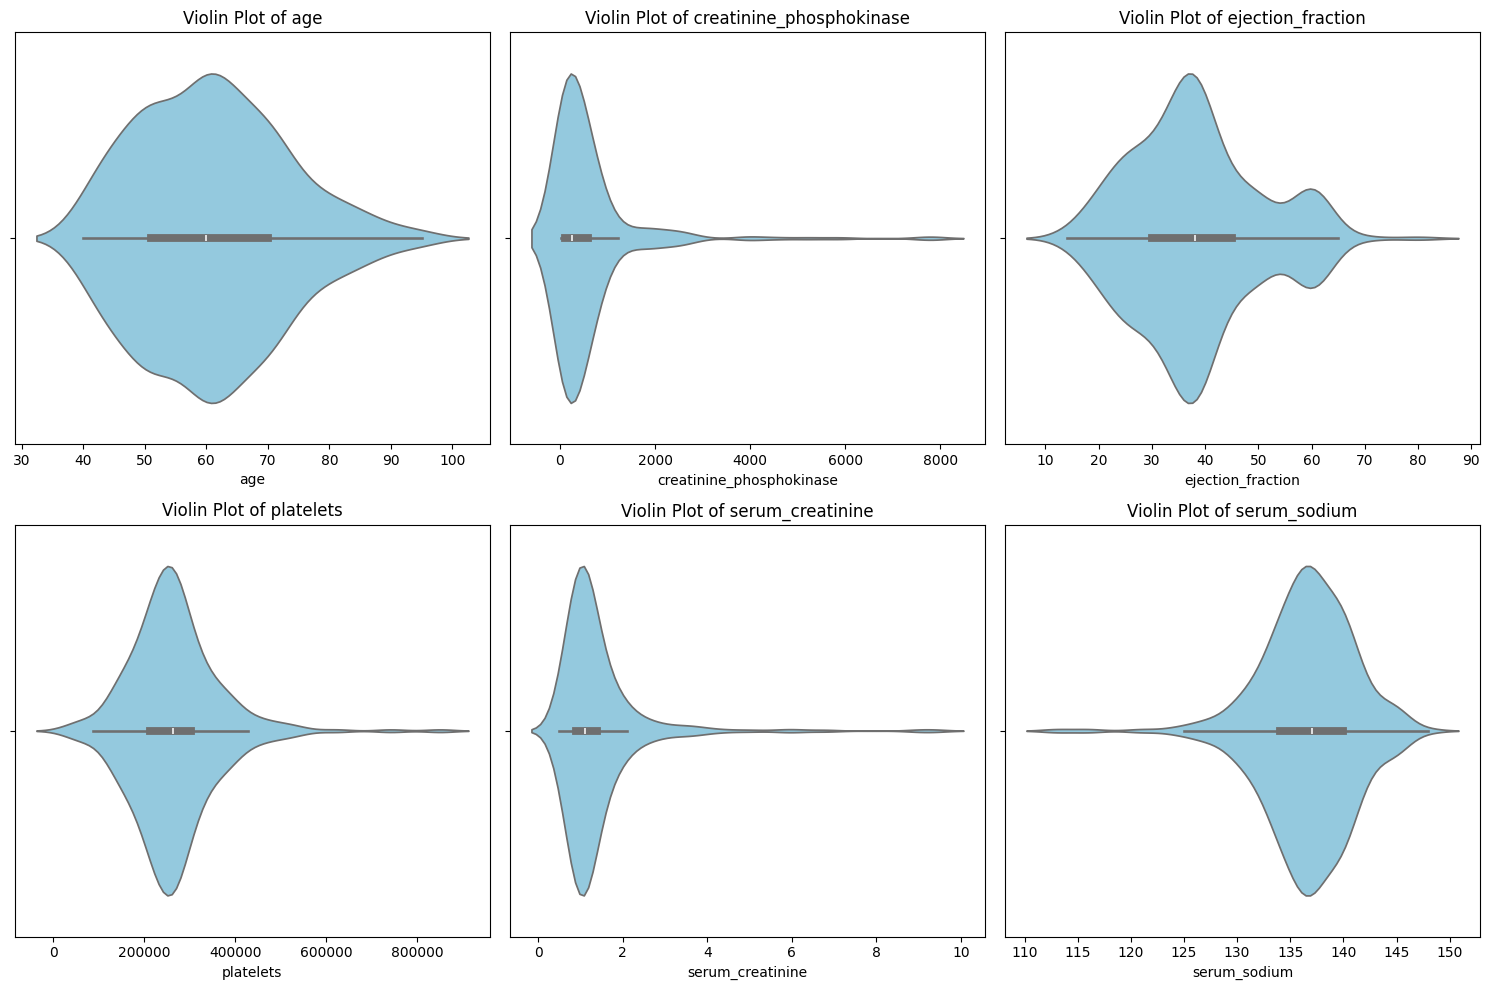

In [71]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(x=df[col], color='skyblue')
    plt.title(f'Violin Plot of {col}')
plt.tight_layout()
plt.show()

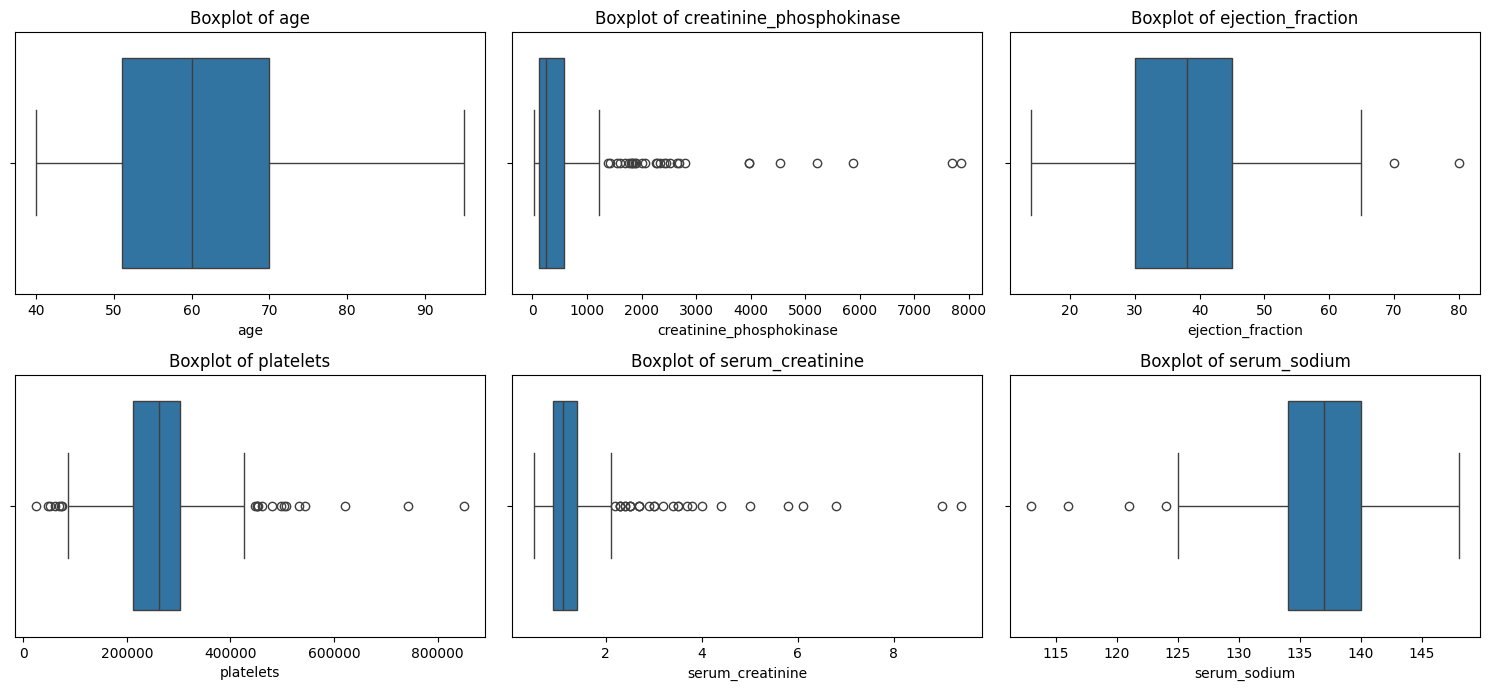

In [72]:
# Handle Outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [73]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3st quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1) 
    
    return multiple_outliers

df.loc[detect_outliers(df,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"])]

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
38   60.0        0                      2656         1                 30   
52   60.0        0                      3964         1                 62   
163  50.0        1                      2334         1                 35   
200  63.0        1                      1767         0                 45   
296  45.0        0                      2060         1                 60   
217  54.0        1                       427         0                 70   
117  85.0        1                       102         0                 60   
167  59.0        0                        66         1                 20   
281  70.0        0                       582         0                 40   
4    65.0        1                       160         1                 20   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
38                     0  305000.00               2.3           137    1   
52                     0  263358.03               6.8           146    0   
163                    0   75000.00               0.9           142    0   
200                    0   73000.00               0.7           137    1   
296                    0  742000.00               0.8           138    0   
217                    1  151000.00               9.0           137    0   
117                    0  507000.00               3.2           138    0   
167                    0   70000.00               2.4           134    1   
281                    0   51000.00               2.7           136    1   
4                      0  327000.00               2.7           116    0   

     smoking  time  DEATH_EVENT  
38         0    30            0  
52         0    43            1  
163        0   126            1  
200        0   186            0  
296        0   278            0  
217        0   196            1  
117        0    94            0  
167        0   135            1  
281        1   250            0  
4          0     8            1

In [74]:
df = df.drop(detect_outliers(df,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]),axis = 0).reset_index(drop=True)

In [75]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

skewed
creatinine_phosphokinase  4.827396
serum_creatinine          4.605615
platelets                 1.429547
DEATH_EVENT               0.797132
smoking                   0.729243
high_blood_pressure       0.583959
ejection_fraction         0.546146
age                       0.413840
diabetes                  0.358569
anaemia                   0.286636
time                      0.125442
sex                      -0.663509
serum_sodium             -0.855445

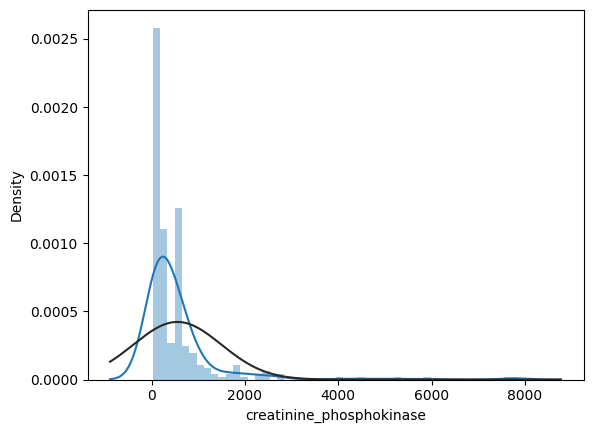

mu creatinine_phosphokinase : 553.121107266436, sigma creatinine_phosphokinase : 943.411428667967



In [76]:
# creatinine_phosphokinase
sns.distplot(df["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["creatinine_phosphokinase"])
print("mu {} : {}, sigma {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))
print()

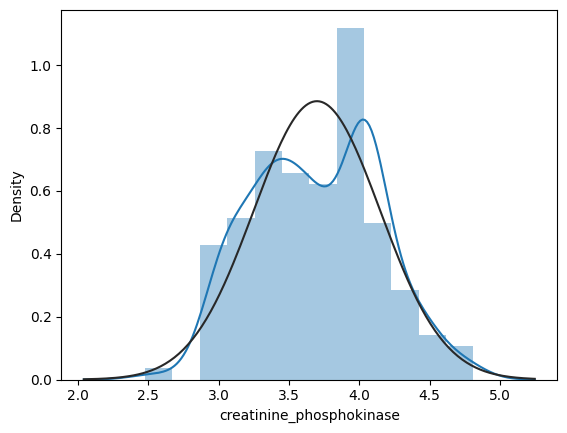

mu creatinine_phosphokinase : 3.698843192632427, sigma creatinine_phosphokinase : 0.45042552009372727



In [77]:
df["creatinine_phosphokinase"], lam = boxcox(df["creatinine_phosphokinase"])
# creatinine_phosphokinase
sns.distplot(df["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["creatinine_phosphokinase"])
print("mu {} : {}, sigma {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))
print()

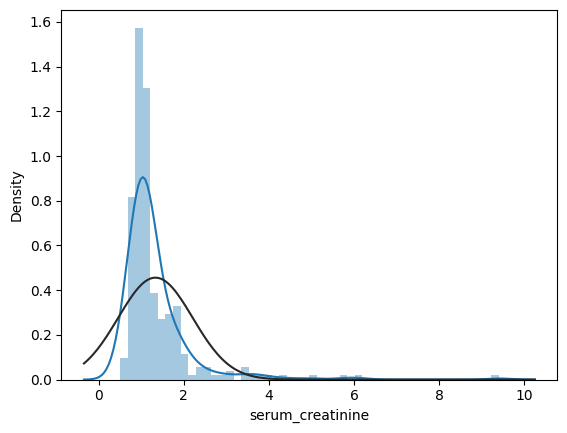

mu serum_creatinine : 1.333114186851211, sigma serum_creatinine : 0.8748528244624999



In [78]:
# serum_creatinine
sns.distplot(df["serum_creatinine"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["serum_creatinine"])
print("mu {} : {}, sigma {} : {}".format("serum_creatinine", mu, "serum_creatinine", sigma))
print()

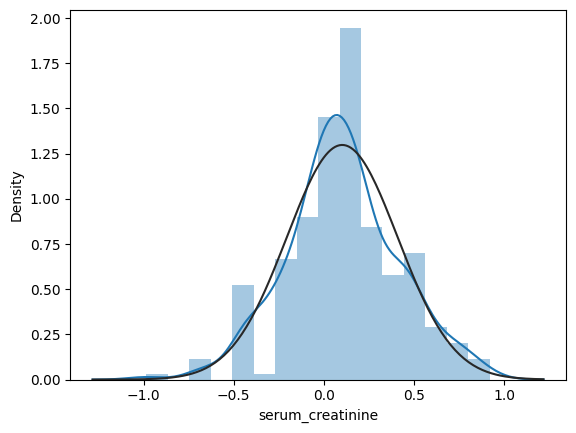

mu serum_creatinine : 0.10109147142703136, sigma serum_creatinine : 0.307317676035967



In [79]:
# serum_creatinine
df["serum_creatinine"], lam_serum_creatine = boxcox(df["serum_creatinine"])
sns.distplot(df["serum_creatinine"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["serum_creatinine"])
print("mu {} : {}, sigma {} : {}".format("serum_creatinine", mu, "serum_creatinine", sigma))
print()

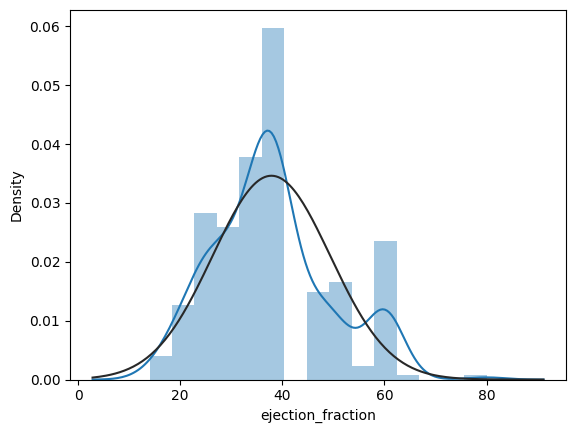

mu ejection_fraction : 37.8719723183391, sigma smejection_fractionoking : 11.526149444782293



In [80]:
# ejection_fraction
sns.distplot(df["ejection_fraction"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["ejection_fraction"])
print("mu {} : {}, sigma {} : {}".format("ejection_fraction", mu, "smejection_fractionoking", sigma))
print()

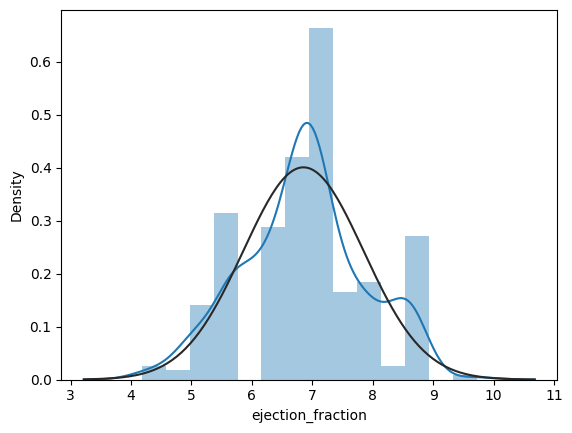

mu ejection_fraction : 6.8528620474651465, sigma smejection_fractionoking : 0.9951607569736975



In [81]:
# ejection_fraction
df["ejection_fraction"], lam_serum_creatine = boxcox(df["ejection_fraction"])
sns.distplot(df["ejection_fraction"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["ejection_fraction"])
print("mu {} : {}, sigma {} : {}".format("ejection_fraction", mu, "smejection_fractionoking", sigma))
print()

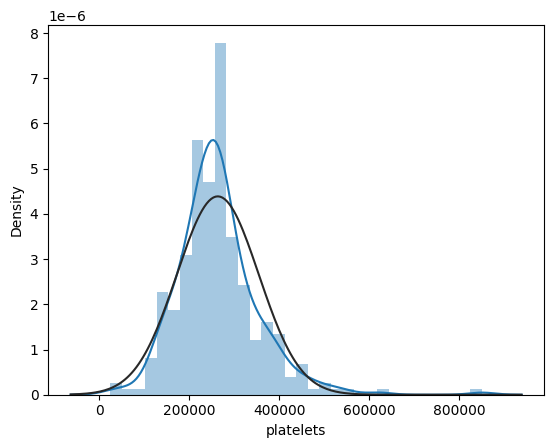

mu platelets : 263597.55266435986, sigma platelets : 90929.19587502987



In [82]:
# platelets
sns.distplot(df["platelets"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["platelets"])
print("mu {} : {}, sigma {} : {}".format("platelets", mu, "platelets", sigma))
print()

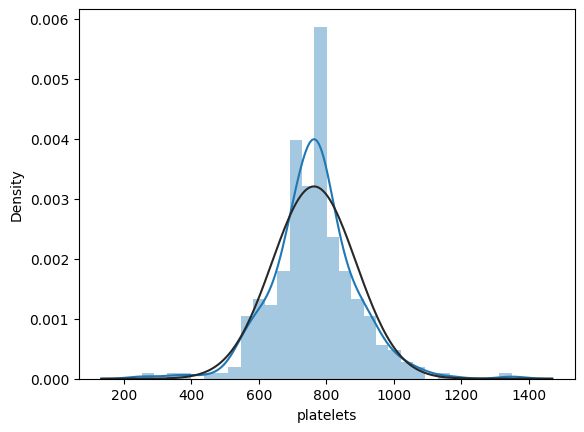

mu platelets : 763.3362284778574, sigma platelets : 124.37243759174682



In [83]:
df["platelets"], lam_serum_creatine = boxcox(df["platelets"])
# platelets
sns.distplot(df["platelets"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(df["platelets"])
print("mu {} : {}, sigma {} : {}".format("platelets", mu, "platelets", sigma))
print()

In [84]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness_new = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness_new

skewed
DEATH_EVENT               0.797132
smoking                   0.729243
high_blood_pressure       0.583959
age                       0.413840
diabetes                  0.358569
anaemia                   0.286636
platelets                 0.153154
time                      0.125442
creatinine_phosphokinase  0.038332
serum_creatinine         -0.005096
ejection_fraction        -0.005676
sex                      -0.663509
serum_sodium             -0.855445

In [85]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

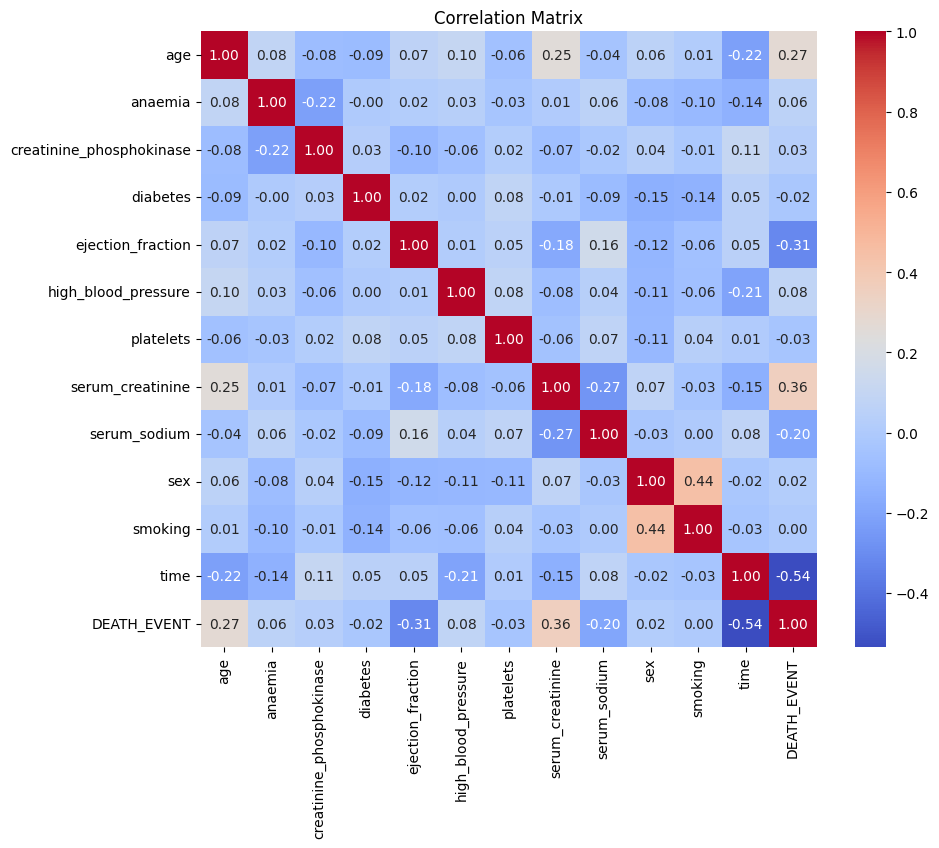

In [86]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()


In [87]:
categorical_cols = ['anaemia', 'diabetes', 'sex', 'smoking', 'high_blood_pressure']

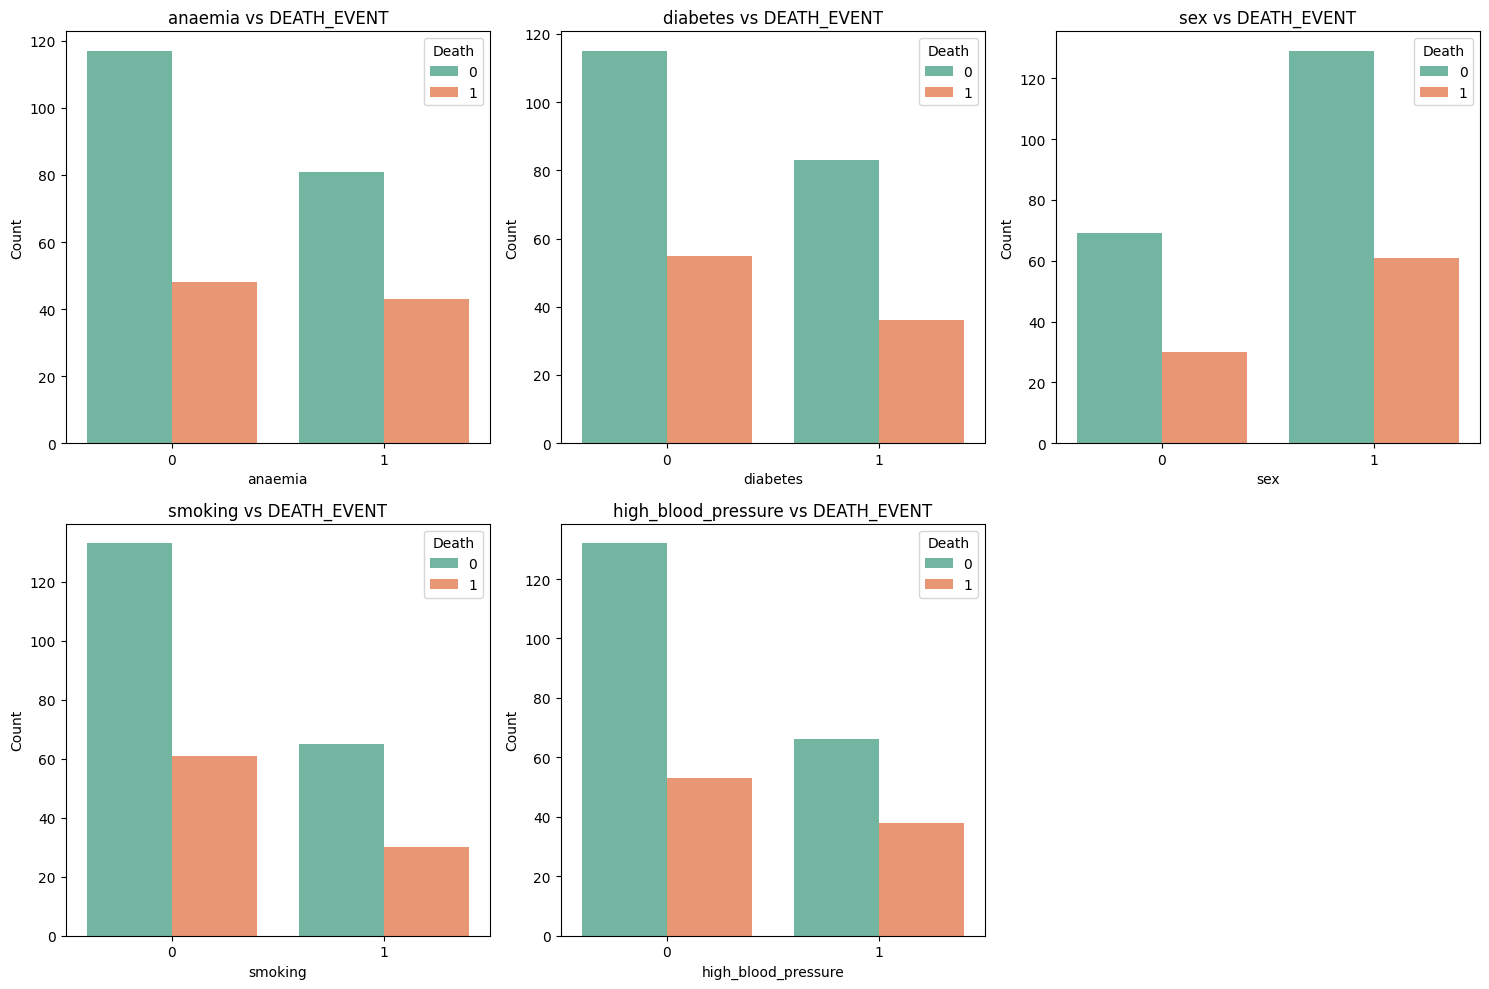

In [88]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='DEATH_EVENT', data=df, palette='Set2')
    plt.title(f'{col} vs DEATH_EVENT')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Death')
    
plt.tight_layout()
plt.show()


In [89]:
for col in categorical_cols:
    rate = df.groupby(col)['DEATH_EVENT'].mean()
    print(f'\nDeath Rate by {col}:')
    print(rate * 100)



Death Rate by anaemia:
anaemia
0    29.090909
1    34.677419
Name: DEATH_EVENT, dtype: float64

Death Rate by diabetes:
diabetes
0    32.352941
1    30.252101
Name: DEATH_EVENT, dtype: float64

Death Rate by sex:
sex
0    30.303030
1    32.105263
Name: DEATH_EVENT, dtype: float64

Death Rate by smoking:
smoking
0    31.443299
1    31.578947
Name: DEATH_EVENT, dtype: float64

Death Rate by high_blood_pressure:
high_blood_pressure
0    28.648649
1    36.538462
Name: DEATH_EVENT, dtype: float64


## Scaling Strategy for Multiple Models

Since different ML models have different requirements, we will use two versions of the Scaling data:

---

## Model Scaling Summary

| Model                | Needs Scaling? |
|----------------------|----------------|
| Logistic Regression  | Yes         |
| K-Nearest Neighbors  | Yes         |
| Support Vector Machine | Yes       |
| Naive Bayes          | Recommended |
| Decision Tree        | No          |
| Random Forest        | No          |
| XGBoost              | No          |
| LightGBM / CatBoost  | No          |


## General Preprocessing

In [90]:
# Split X, y
X = df.drop("DEATH_EVENT", axis=1)
y = df["DEATH_EVENT"]

print(f"Before Smote {y.value_counts()}")

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print(f"After Smote {y_resampled.value_counts()}")

# Train-test split (after SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Apply Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# # to store model evaluation results
results_list = [] 


Before Smote DEATH_EVENT
0    198
1     91
Name: count, dtype: int64
After Smote DEATH_EVENT
1    198
0    198
Name: count, dtype: int64


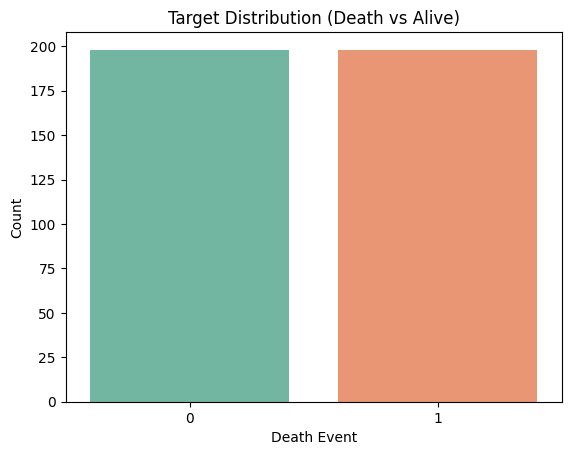

In [91]:
# Distribution of Target (DEATH_EVENT)
yy = pd.DataFrame(y_resampled)
sns.countplot(x='DEATH_EVENT' , data=yy  , palette='Set2')
plt.title("Target Distribution (Death vs Alive)")
plt.xlabel("Death Event")
plt.ylabel("Count")
plt.show()

## Logistic Regression (*needs scaling*)

              precision    recall  f1-score   support

           0       0.79      0.95      0.86        39
           1       0.94      0.76      0.84        41

    accuracy                           0.85        80
   macro avg       0.86      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80



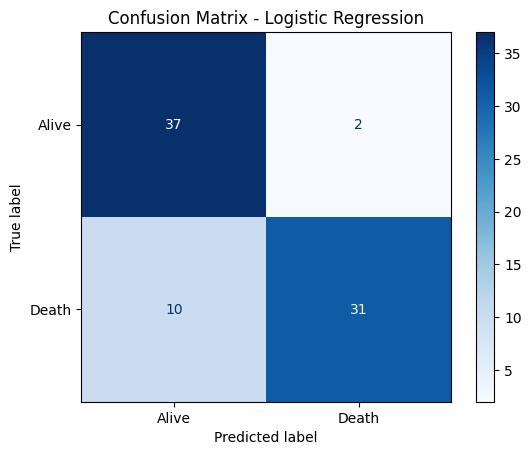

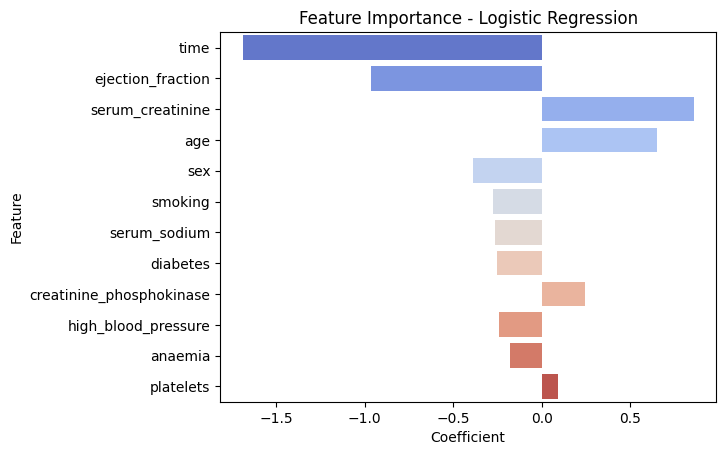

In [92]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Feature Coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)



sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Feature Importance - Logistic Regression")
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "LogisticRegression",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})


## K-Nearest Neighbors (needs scaling)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        39
           1       0.83      0.85      0.84        41

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



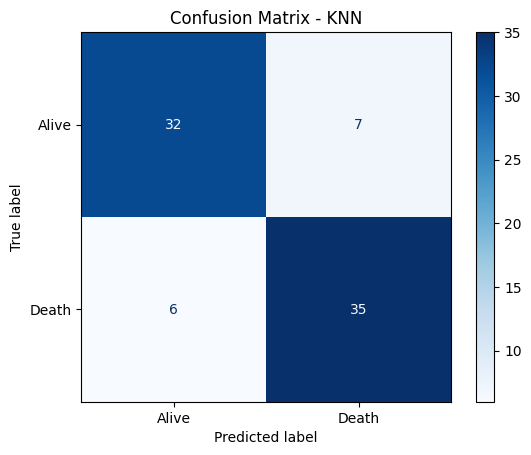

In [93]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - KNN")
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "KNN",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})

## Support Vector Machine (needs scaling)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88        39
           1       0.94      0.80      0.87        41

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.87        80



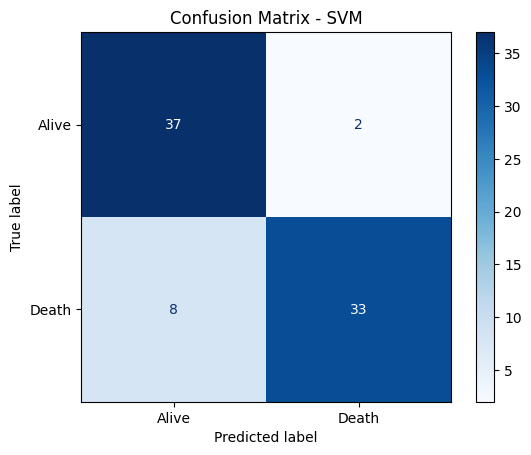

In [94]:
svm = SVC(probability=True)
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "SVM",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})

## Naive Bayes (needs scaling - *optional*)

              precision    recall  f1-score   support

           0       0.76      0.90      0.82        39
           1       0.88      0.73      0.80        41

    accuracy                           0.81        80
   macro avg       0.82      0.81      0.81        80
weighted avg       0.82      0.81      0.81        80



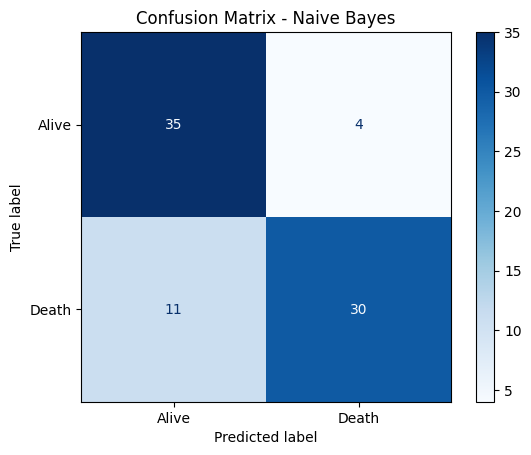

In [95]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

y_pred = nb.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "Naive Bayes",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})


##  Decision Tree (no scaling)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        39
           1       0.79      0.80      0.80        41

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



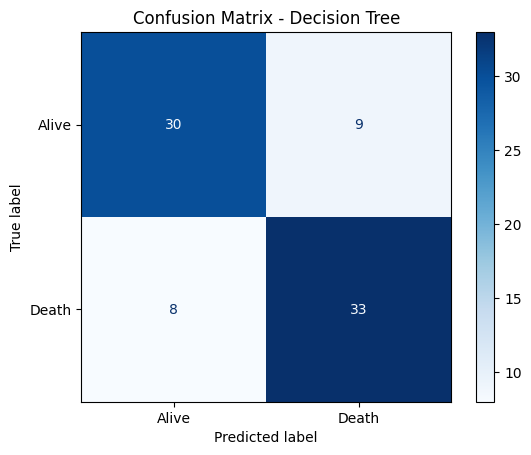

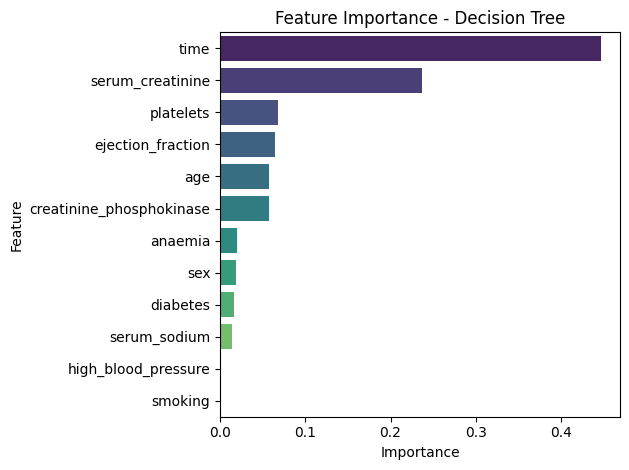

In [96]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Feature Importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)


sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Feature Importance - Decision Tree')
plt.tight_layout()
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "Decision Tree",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})

##  Random Forest (no scaling)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.95      0.95      0.95        41

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



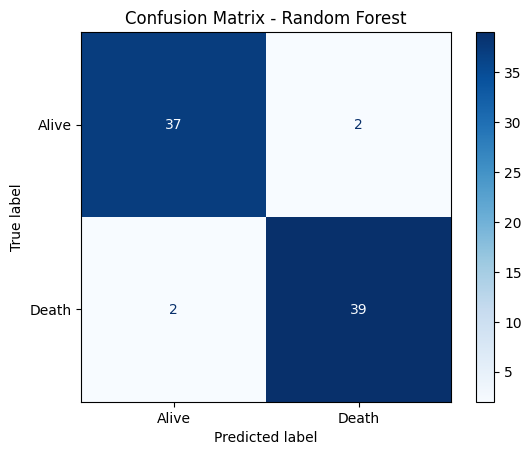

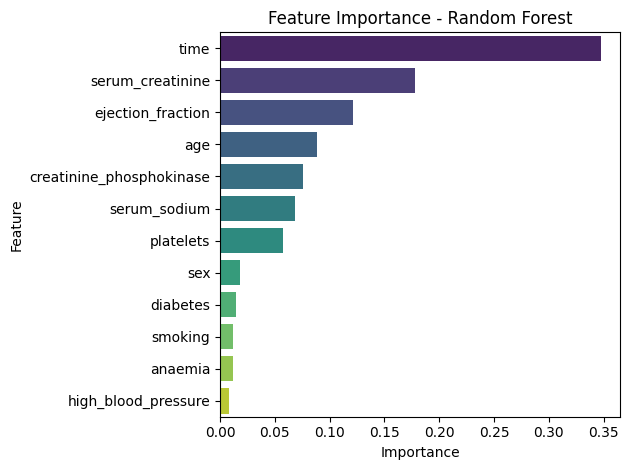

In [97]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Feature Importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "Random Forest",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})

## XGBoost (no scaling)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        39
           1       0.95      0.93      0.94        41

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



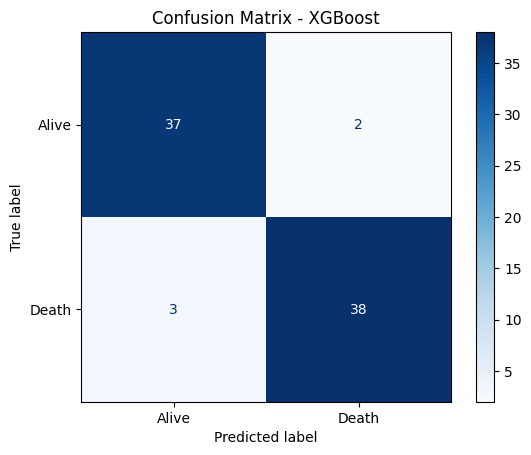

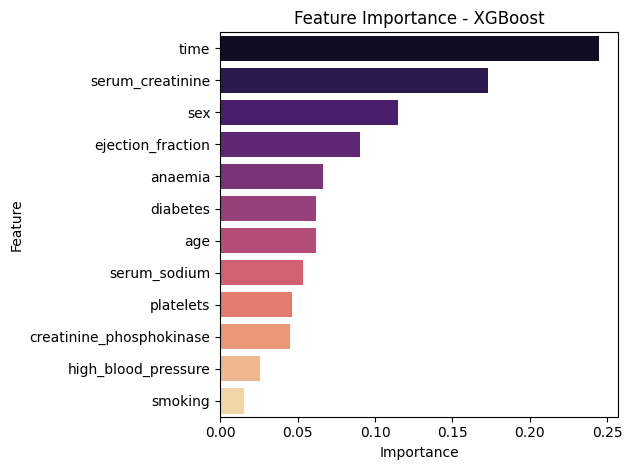

In [98]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Feature Importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)


sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='magma')
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "XGBoost",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})

##  LightGBM (no scaling)

[LightGBM] [Info] Number of positive: 157, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496835 -> initscore=-0.012658
[LightGBM] [Info] Start training from score -0.012658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

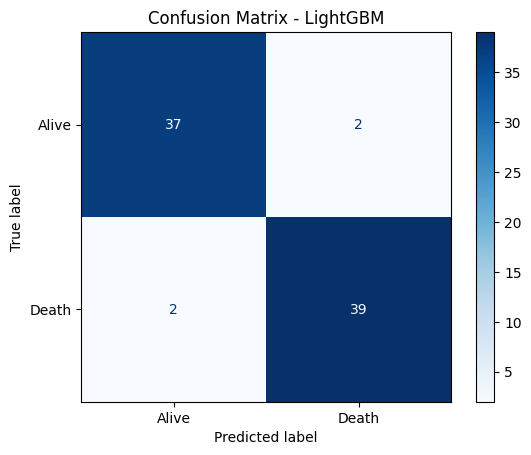

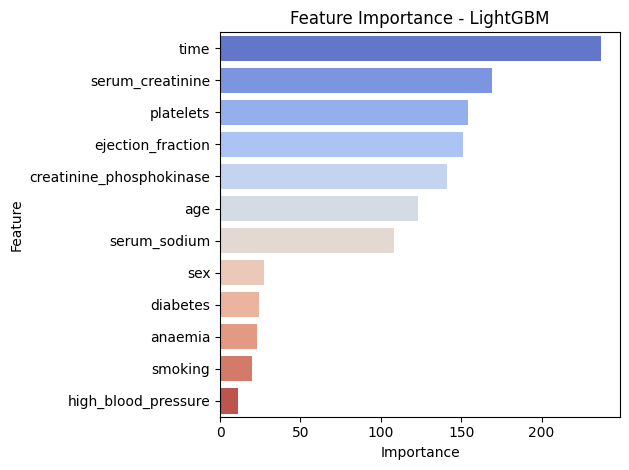

In [99]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Alive", "Death"]).plot(cmap="Blues")
plt.title("Confusion Matrix - LightGBM")
plt.show()

# Feature Importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)


sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='coolwarm')
plt.title('Feature Importance - LightGBM')
plt.tight_layout()
plt.show()

# Evaluate Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)  # OR y_proba if available

# Store in list
results_list.append({
    "Model": "LightGBM",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC-AUC": roc
})

## Evaluation

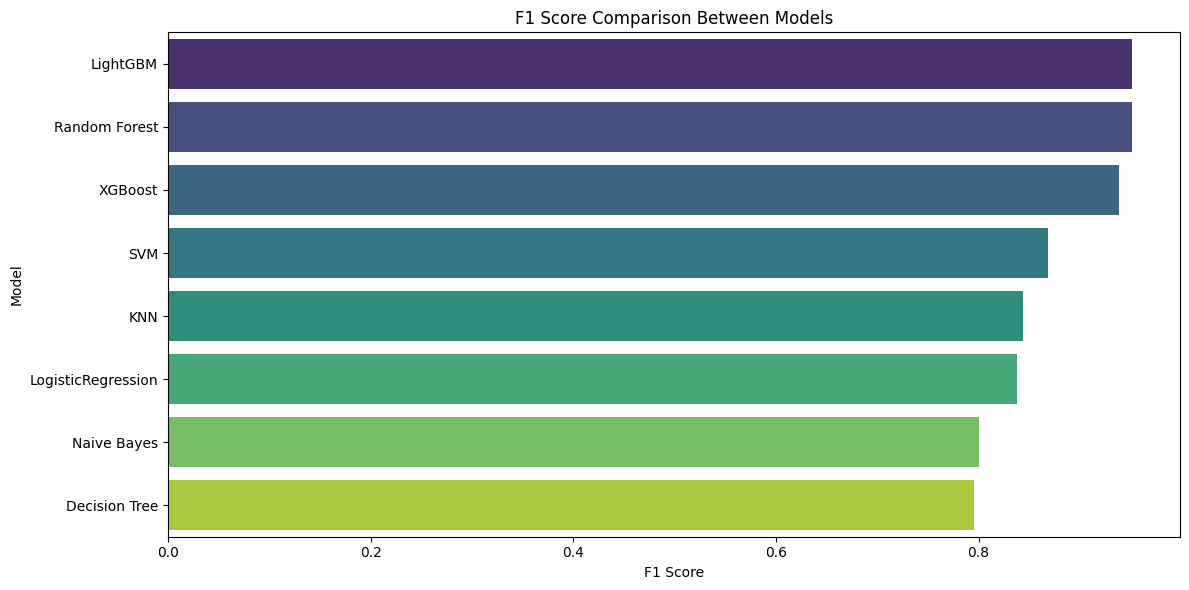

Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0            LightGBM    0.9500   0.951220  0.951220  0.951220  0.949969
1       Random Forest    0.9500   0.951220  0.951220  0.951220  0.949969
2             XGBoost    0.9375   0.950000  0.926829  0.938272  0.937774
3                 SVM    0.8750   0.942857  0.804878  0.868421  0.876798
4                 KNN    0.8375   0.833333  0.853659  0.843373  0.837086
5  LogisticRegression    0.8500   0.939394  0.756098  0.837838  0.852408
6         Naive Bayes    0.8125   0.882353  0.731707  0.800000  0.814572
7       Decision Tree    0.7875   0.785714  0.804878  0.795181  0.787054

In [100]:
results_df = pd.DataFrame(results_list).sort_values(by="F1-Score", ascending=False)
results_df.reset_index(drop=True, inplace=True)


# Plot F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x="F1-Score", y="Model", data=results_df, palette="viridis")
plt.title("F1 Score Comparison Between Models")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
# Display table
results_df


# Final Choice Justification: StandardScaler + LightGBM

## Evaluation Summary

Multiple scalers were tested (`StandardScaler`, `MinMaxScaler`, `RobustScaler`, `MaxAbsScaler`) across several classification models.

The following table shows full evaluation results. **LightGBM with StandardScaler** consistently achieved **top performance** across all metrics.

---

## Results by Scaler

### 🔹 StandardScaler

| Model              | Accuracy | Precision | Recall   | F1-Score | ROC-AUC  |
|--------------------|----------|-----------|----------|----------|----------|
| **LightGBM**       | **0.9500** | **0.951220** | **0.951220** | **0.951220** | **0.949969** |
| XGBoost            | 0.9375   | 0.950000  | 0.926829 | 0.938272 | 0.937774 |
| Random Forest      | 0.9000   | 0.923077  | 0.878049 | 0.900000 | 0.900563 |
| SVM                | 0.8750   | 0.942857  | 0.804878 | 0.868421 | 0.876798 |
| KNN                | 0.8375   | 0.833333  | 0.853659 | 0.843373 | 0.837086 |
| LogisticRegression | 0.8500   | 0.939394  | 0.756098 | 0.837838 | 0.852408 |
| Decision Tree      | 0.8000   | 0.804878  | 0.804878 | 0.804878 | 0.799875 |
| Naive Bayes        | 0.8125   | 0.882353  | 0.731707 | 0.800000 | 0.814572 |

---

### 🔹 MinMaxScaler

| Model              | Accuracy | Precision | Recall   | F1-Score | ROC-AUC  |
|--------------------|----------|-----------|----------|----------|----------|
| **LightGBM**       | **0.9500** | **0.951220** | **0.951220** | **0.951220** | **0.949969** |
| XGBoost            | 0.9375   | 0.950000  | 0.926829 | 0.938272 | 0.937774 |
| Random Forest      | 0.9125   | 0.925000  | 0.902439 | 0.913580 | 0.912758 |
| SVM                | 0.8625   | 0.894737  | 0.829268 | 0.860759 | 0.863352 |
| LogisticRegression | 0.8375   | 0.868421  | 0.804878 | 0.835443 | 0.838336 |
| Naive Bayes        | 0.8125   | 0.882353  | 0.731707 | 0.800000 | 0.814572 |
| Decision Tree      | 0.7875   | 0.785714  | 0.804878 | 0.795181 | 0.787054 |
| KNN                | 0.7750   | 0.794872  | 0.756098 | 0.775000 | 0.775485 |

---

### 🔹 RobustScaler

| Model              | Accuracy | Precision | Recall   | F1-Score | ROC-AUC  |
|--------------------|----------|-----------|----------|----------|----------|
| **LightGBM**       | **0.9500** | **0.951220** | **0.951220** | **0.951220** | **0.949969** |
| XGBoost            | 0.9375   | 0.950000  | 0.926829 | 0.938272 | 0.937774 |
| Random Forest      | 0.9250   | 0.926829  | 0.926829 | 0.926829 | 0.924953 |
| SVM                | 0.8625   | 0.916667  | 0.804878 | 0.857143 | 0.863977 |
| KNN                | 0.8375   | 0.833333  | 0.853659 | 0.843373 | 0.837086 |
| LogisticRegression | 0.8375   | 0.911765  | 0.756098 | 0.826667 | 0.839587 |
| Naive Bayes        | 0.8125   | 0.882353  | 0.731707 | 0.800000 | 0.814572 |
| Decision Tree      | 0.7750   | 0.767442  | 0.804878 | 0.785714 | 0.774234 |

---

### 🔹 MaxAbsScaler

| Model              | Accuracy | Precision | Recall   | F1-Score | ROC-AUC  |
|--------------------|----------|-----------|----------|----------|----------|
| **LightGBM**       | **0.9500** | **0.951220** | **0.951220** | **0.951220** | **0.949969** |
| XGBoost            | 0.9375   | 0.950000  | 0.926829 | 0.938272 | 0.937774 |
| Random Forest      | 0.9250   | 0.926829  | 0.926829 | 0.926829 | 0.924953 |
| SVM                | 0.8500   | 0.871795  | 0.829268 | 0.850000 | 0.850532 |
| LogisticRegression | 0.8125   | 0.825000  | 0.804878 | 0.814815 | 0.812695 |
| Decision Tree      | 0.8000   | 0.804878  | 0.804878 | 0.804878 | 0.799875 |
| Naive Bayes        | 0.8125   | 0.882353  | 0.731707 | 0.800000 | 0.814572 |
| KNN                | 0.6875   | 0.690476  | 0.707317 | 0.698795 | 0.686992 |

---

## Final Decision

- **Scaler**: `StandardScaler`
- **Model**: `LightGBM`

> This combination provided the **highest overall performance** and will be used in the final deployment pipeline.


In [101]:
# Objective Function using Cross-Validation
def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    
    model = LGBMClassifier(**params, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return f1.mean()

In [ ]:
# Run Optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

[I 2025-07-16 20:40:47,669] A new study created in memory with name: no-name-8b068341-7e16-4ce5-bf64-a44c6ca5c087


[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:40:48,253] Trial 0 finished with value: 0.8635963727306436 and parameters: {'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.2533749395925388, 'n_estimators': 143, 'min_child_samples': 15, 'subsample': 0.6845016194096685, 'colsample_bytree': 0.9142657356450178}. Best is trial 0 with value: 0.8635963727306436.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:40:48,635] Trial 1 finished with value: 0.8543499511241446 and parameters: {'num_leaves': 96, 'max_depth': 6, 'learning_rate': 0.22990530930152034, 'n_estimators': 114, 'min_child_samples': 40, 'subsample': 0.8110100718630795, 'colsample_bytree': 0.528770611125218}. Best is trial 0 with value: 0.8635963727306436.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:40:49,042] Trial 2 finished with value: 0.8550342825740034 and parameters: {'num_leaves': 81, 'max_depth': 4, 'learning_rate': 0.1522694410983177, 'n_estimators': 177, 'min_child_samples': 43, 'subsample': 0.8953370750706784, 'colsample_bytree': 0.8869151189837763}. Best is trial 0 with value: 0.8635963727306436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:50,360] Trial 3 finished with value: 0.8549253136520054 and parameters: {'num_leaves': 44, 'max_depth': 7, 'learning_rate': 0.08592243166118656, 'n_estimators': 234, 'min_child_samples': 11, 'subsample': 0.9691465174764731, 'colsample_bytree': 0.5569788605122039}. Best is trial 0 with value: 0.8635963727306436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:50,793] Trial 4 finished with value: 0.8469719715621356 and parameters: {'num_leaves': 74, 'max_depth': 3, 'learning_rate': 0.20076059389093875, 'n_estimators': 176, 'min_child_samples': 40, 'subsample': 0.6576725455007071, 'colsample_bytree': 0.5556041472623672}. Best is trial 0 with value: 0.8635963727306436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:51,594] Trial 5 finished with value: 0.8605524849192813 and parameters: {'num_leaves': 85, 'max_depth': 5, 'learning_rate': 0.21841038114705094, 'n_estimators': 273, 'min_child_samples': 15, 'subsample': 0.8258727283650416, 'colsample_bytree': 0.5064111833240725}. Best is trial 0 with value: 0.8635963727306436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:51,890] Trial 6 finished with value: 0.8638846374552138 and parameters: {'num_leaves': 22, 'max_depth': 8, 'learning_rate': 0.14866969945900937, 'n_estimators': 103, 'min_child_samples': 37, 'subsample': 0.8532120087679567, 'colsample_bytree': 0.992287283932427}. Best is trial 6 with value: 0.8638846374552138.


[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:40:52,319] Trial 7 finished with value: 0.8578612223655121 and parameters: {'num_leaves': 98, 'max_depth': 10, 'learning_rate': 0.22591537196511352, 'n_estimators': 170, 'min_child_samples': 34, 'subsample': 0.5352028812963726, 'colsample_bytree': 0.5835341799687273}. Best is trial 6 with value: 0.8638846374552138.


[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:40:53,185] Trial 8 finished with value: 0.8542510547798756 and parameters: {'num_leaves': 98, 'max_depth': 9, 'learning_rate': 0.18805947385168895, 'n_estimators': 283, 'min_child_samples': 20, 'subsample': 0.9453896207511674, 'colsample_bytree': 0.5059033656848605}. Best is trial 6 with value: 0.8638846374552138.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:53,852] Trial 9 finished with value: 0.8669914172727287 and parameters: {'num_leaves': 44, 'max_depth': 8, 'learning_rate': 0.07826366037530723, 'n_estimators': 140, 'min_child_samples': 12, 'subsample': 0.8674342214662343, 'colsample_bytree': 0.8488323489912145}. Best is trial 9 with value: 0.8669914172727287.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:54,571] Trial 10 finished with value: 0.8722907959842641 and parameters: {'num_leaves': 47, 'max_depth': 8, 'learning_rate': 0.053258400597144054, 'n_estimators': 221, 'min_child_samples': 23, 'subsample': 0.7090230132939475, 'colsample_bytree': 0.7306679761076681}. Best is trial 10 with value: 0.8722907959842641.


[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:40:55,236] Trial 11 finished with value: 0.8653428439262079 and parameters: {'num_leaves': 52, 'max_depth': 8, 'learning_rate': 0.010492007770828808, 'n_estimators': 224, 'min_child_samples': 25, 'subsample': 0.7331346155757928, 'colsample_bytree': 0.7356497266024744}. Best is trial 10 with value: 0.8722907959842641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:56,007] Trial 12 finished with value: 0.8689318147597447 and parameters: {'num_leaves': 37, 'max_depth': 10, 'learning_rate': 0.06837190586247377, 'n_estimators': 219, 'min_child_samples': 50, 'subsample': 0.6337188498670159, 'colsample_bytree': 0.7354960446615335}. Best is trial 10 with value: 0.8722907959842641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:56,716] Trial 13 finished with value: 0.8677862576880809 and parameters: {'num_leaves': 24, 'max_depth': 10, 'learning_rate': 0.012796505941057523, 'n_estimators': 240, 'min_child_samples': 28, 'subsample': 0.5918827143204365, 'colsample_bytree': 0.7050909201896371}. Best is trial 10 with value: 0.8722907959842641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:57,278] Trial 14 finished with value: 0.8628011587148521 and parameters: {'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.06766780814323861, 'n_estimators': 207, 'min_child_samples': 49, 'subsample': 0.6279043947331434, 'colsample_bytree': 0.6533890937052315}. Best is trial 10 with value: 0.8722907959842641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:58,008] Trial 15 finished with value: 0.8602863262831534 and parameters: {'num_leaves': 51, 'max_depth': 10, 'learning_rate': 0.11888345128941653, 'n_estimators': 261, 'min_child_samples': 50, 'subsample': 0.7445920896523868, 'colsample_bytree': 0.7815425882114587}. Best is trial 10 with value: 0.8722907959842641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:40:59,098] Trial 16 finished with value: 0.8753705604402938 and parameters: {'num_leaves': 65, 'max_depth': 7, 'learning_rate': 0.047513005249592316, 'n_estimators': 298, 'min_child_samples': 24, 'subsample': 0.5272256007073031, 'colsample_bytree': 0.6497185160841028}. Best is trial 16 with value: 0.8753705604402938.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:00,115] Trial 17 finished with value: 0.8721308875413272 and parameters: {'num_leaves': 63, 'max_depth': 7, 'learning_rate': 0.0444421751513267, 'n_estimators': 299, 'min_child_samples': 22, 'subsample': 0.5215801075262603, 'colsample_bytree': 0.6397487320383386}. Best is trial 16 with value: 0.8753705604402938.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:00,862] Trial 18 finished with value: 0.8710915468739253 and parameters: {'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.11468147003873481, 'n_estimators': 258, 'min_child_samples': 31, 'subsample': 0.5924363659417096, 'colsample_bytree': 0.8045545661603704}. Best is trial 16 with value: 0.8753705604402938.


[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:41:01,739] Trial 19 finished with value: 0.8546195096156026 and parameters: {'num_leaves': 54, 'max_depth': 7, 'learning_rate': 0.2999414967106893, 'n_estimators': 291, 'min_child_samples': 27, 'subsample': 0.7106462276960145, 'colsample_bytree': 0.670428334131091}. Best is trial 16 with value: 0.8753705604402938.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:02,467] Trial 20 finished with value: 0.8705976125073992 and parameters: {'num_leaves': 66, 'max_depth': 9, 'learning_rate': 0.03594678347703134, 'n_estimators': 196, 'min_child_samples': 20, 'subsample': 0.7858649315036144, 'colsample_bytree': 0.6390695782477057}. Best is trial 16 with value: 0.8753705604402938.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:41:03,371] Trial 21 finished with value: 0.8716839244955933 and parameters: {'num_leaves': 67, 'max_depth': 7, 'learning_rate': 0.04245034120150374, 'n_estimators': 253, 'min_child_samples': 22, 'subsample': 0.5066028407913624, 'colsample_bytree': 0.6136656070927545}. Best is trial 16 with value: 0.8753705604402938.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:04,381] Trial 22 finished with value: 0.8758031799514336 and parameters: {'num_leaves': 57, 'max_depth': 6, 'learning_rate': 0.04037785031822137, 'n_estimators': 294, 'min_child_samples': 23, 'subsample': 0.5540030840406548, 'colsample_bytree': 0.6897720471720165}. Best is trial 22 with value: 0.8758031799514336.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:05,339] Trial 23 finished with value: 0.871858176473124 and parameters: {'num_leaves': 58, 'max_depth': 5, 'learning_rate': 0.10543544306252538, 'n_estimators': 276, 'min_child_samples': 24, 'subsample': 0.5728075025727148, 'colsample_bytree': 0.6853448353788074}. Best is trial 22 with value: 0.8758031799514336.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:41:06,568] Trial 24 finished with value: 0.8733910663108736 and parameters: {'num_leaves': 72, 'max_depth': 6, 'learning_rate': 0.04853750166071327, 'n_estimators': 269, 'min_child_samples': 17, 'subsample': 0.5688009215607444, 'colsample_bytree': 0.7707636858299626}. Best is trial 22 with value: 0.8758031799514336.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:07,844] Trial 25 finished with value: 0.8609624833539973 and parameters: {'num_leaves': 76, 'max_depth': 6, 'learning_rate': 0.0943494795025008, 'n_estimators': 299, 'min_child_samples': 16, 'subsample': 0.5583104915997806, 'colsample_bytree': 0.7815572627178079}. Best is trial 22 with value: 0.8758031799514336.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:08,705] Trial 26 finished with value: 0.8734532444481712 and parameters: {'num_leaves': 74, 'max_depth': 4, 'learning_rate': 0.0260684542051546, 'n_estimators': 271, 'min_child_samples': 18, 'subsample': 0.5034577083351899, 'colsample_bytree': 0.7024208086725988}. Best is trial 22 with value: 0.8758031799514336.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:09,421] Trial 27 finished with value: 0.8812377755072252 and parameters: {'num_leaves': 91, 'max_depth': 3, 'learning_rate': 0.021705702995390767, 'n_estimators': 282, 'min_child_samples': 31, 'subsample': 0.5038213906441533, 'colsample_bytree': 0.6046910820346347}. Best is trial 27 with value: 0.8812377755072252.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:10,091] Trial 28 finished with value: 0.8614164259854371 and parameters: {'num_leaves': 93, 'max_depth': 3, 'learning_rate': 0.13952943872391732, 'n_estimators': 244, 'min_child_samples': 31, 'subsample': 0.6106821966639953, 'colsample_bytree': 0.5942148761497221}. Best is trial 27 with value: 0.8812377755072252.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:10,959] Trial 29 finished with value: 0.8775360303988169 and parameters: {'num_leaves': 90, 'max_depth': 4, 'learning_rate': 0.02315576290726772, 'n_estimators': 288, 'min_child_samples': 33, 'subsample': 0.6709425174758448, 'colsample_bytree': 0.6130046817777031}. Best is trial 27 with value: 0.8812377755072252.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:41:11,822] Trial 30 finished with value: 0.8832301277851883 and parameters: {'num_leaves': 89, 'max_depth': 4, 'learning_rate': 0.025151645879202038, 'n_estimators': 286, 'min_child_samples': 35, 'subsample': 0.6713384132340455, 'colsample_bytree': 0.6081374404707215}. Best is trial 30 with value: 0.8832301277851883.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:41:12,642] Trial 31 finished with value: 0.886716739580893 and parameters: {'num_leaves': 91, 'max_depth': 4, 'learning_rate': 0.02916354102687173, 'n_estimators': 284, 'min_child_samples': 33, 'subsample': 0.6734058799538801, 'colsample_bytree': 0.6042248787158649}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:13,380] Trial 32 finished with value: 0.8758768561187915 and parameters: {'num_leaves': 91, 'max_depth': 4, 'learning_rate': 0.020517161891190676, 'n_estimators': 281, 'min_child_samples': 34, 'subsample': 0.6806196854186735, 'colsample_bytree': 0.6069250221322622}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:41:14,112] Trial 33 finished with value: 0.8716254953520239 and parameters: {'num_leaves': 86, 'max_depth': 4, 'learning_rate': 0.0622352152888703, 'n_estimators': 251, 'min_child_samples': 34, 'subsample': 0.6631190494978594, 'colsample_bytree': 0.5491732190244326}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:14,755] Trial 34 finished with value: 0.8833968362596227 and parameters: {'num_leaves': 91, 'max_depth': 3, 'learning_rate': 0.02659554436168083, 'n_estimators': 264, 'min_child_samples': 38, 'subsample': 0.7600692490431281, 'colsample_bytree': 0.5719472975625557}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:41:15,478] Trial 35 finished with value: 0.8443783367170464 and parameters: {'num_leaves': 79, 'max_depth': 3, 'learning_rate': 0.08563886701901445, 'n_estimators': 263, 'min_child_samples': 43, 'subsample': 0.7795827515813731, 'colsample_bytree': 0.5661044096800857}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:41:16,282] Trial 36 finished with value: 0.8659679308000303 and parameters: {'num_leaves': 100, 'max_depth': 3, 'learning_rate': 0.028063727460603486, 'n_estimators': 281, 'min_child_samples': 38, 'subsample': 0.7693367972406515, 'colsample_bytree': 0.5231525034198824}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:16,973] Trial 37 finished with value: 0.8366233766233766 and parameters: {'num_leaves': 82, 'max_depth': 5, 'learning_rate': 0.2595441715197446, 'n_estimators': 246, 'min_child_samples': 43, 'subsample': 0.8160887100840435, 'colsample_bytree': 0.5362372800666435}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:41:17,567] Trial 38 finished with value: 0.8669311916891396 and parameters: {'num_leaves': 87, 'max_depth': 3, 'learning_rate': 0.06069434058052396, 'n_estimators': 236, 'min_child_samples': 37, 'subsample': 0.7064675366306767, 'colsample_bytree': 0.5764172582491912}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:18,025] Trial 39 finished with value: 0.8713064624757006 and parameters: {'num_leaves': 95, 'max_depth': 4, 'learning_rate': 0.07797684129809498, 'n_estimators': 152, 'min_child_samples': 40, 'subsample': 0.9290036304073221, 'colsample_bytree': 0.9442823307037601}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:41:18,729] Trial 40 finished with value: 0.8455749268652495 and parameters: {'num_leaves': 88, 'max_depth': 3, 'learning_rate': 0.18009908568574723, 'n_estimators': 273, 'min_child_samples': 46, 'subsample': 0.6405422490237193, 'colsample_bytree': 0.6281741643947596}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:19,636] Trial 41 finished with value: 0.8811202597894979 and parameters: {'num_leaves': 91, 'max_depth': 4, 'learning_rate': 0.030938841569712272, 'n_estimators': 289, 'min_child_samples': 33, 'subsample': 0.6782033789423285, 'colsample_bytree': 0.5966734229965811}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:20,558] Trial 42 finished with value: 0.8653428439262079 and parameters: {'num_leaves': 94, 'max_depth': 5, 'learning_rate': 0.010287451565281932, 'n_estimators': 286, 'min_child_samples': 29, 'subsample': 0.726549005183662, 'colsample_bytree': 0.5849823301178673}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 125, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496032 -> initscore=-0.015873
[LightGBM] [Info] Start training from score -0.015873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-16 20:41:21,407] Trial 43 finished with value: 0.8859419921919681 and parameters: {'num_leaves': 81, 'max_depth': 4, 'learning_rate': 0.03275886489582542, 'n_estimators': 270, 'min_child_samples': 36, 'subsample': 0.9941434671142617, 'colsample_bytree': 0.5546504142776378}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:41:22,242] Trial 44 finished with value: 0.8726563992632842 and parameters: {'num_leaves': 82, 'max_depth': 3, 'learning_rate': 0.05949261359521879, 'n_estimators': 266, 'min_child_samples': 39, 'subsample': 0.9940016998993657, 'colsample_bytree': 0.5240862140887628}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:41:22,935] Trial 45 finished with value: 0.8750478271689428 and parameters: {'num_leaves': 78, 'max_depth': 4, 'learning_rate': 0.03437531162739331, 'n_estimators': 230, 'min_child_samples': 36, 'subsample': 0.8863812538312635, 'colsample_bytree': 0.5579067658177884}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:23,635] Trial 46 finished with value: 0.8700924177180125 and parameters: {'num_leaves': 97, 'max_depth': 5, 'learning_rate': 0.022637939615088292, 'n_estimators': 276, 'min_child_samples': 42, 'subsample': 0.8483130302718996, 'colsample_bytree': 0.541305468939083}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:24,263] Trial 47 finished with value: 0.8786498590609005 and parameters: {'num_leaves': 85, 'max_depth': 3, 'learning_rate': 0.06876389187899183, 'n_estimators': 257, 'min_child_samples': 35, 'subsample': 0.9291602401393415, 'colsample_bytree': 0.6683021197219647}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Info] Number of positive: 126, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 253, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498024 -> initscore=-0.007905
[LightGBM] [Info] Start training from score -0.007905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-07-16 20:41:24,900] Trial 48 finished with value: 0.8694351640434919 and parameters: {'num_leaves': 83, 'max_depth': 4, 'learning_rate': 0.05234763928697812, 'n_estimators': 194, 'min_child_samples': 32, 'subsample': 0.7562997913260116, 'colsample_bytree': 0.5021303082603696}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-16 20:41:25,637] Trial 49 finished with value: 0.8627089545495619 and parameters: {'num_leaves': 89, 'max_depth': 3, 'learning_rate': 0.010475095435620651, 'n_estimators': 280, 'min_child_samples': 26, 'subsample': 0.792851107260839, 'colsample_bytree': 0.5761491951464072}. Best is trial 31 with value: 0.886716739580893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [103]:
# Train Final Model with Early Stopping
best_params = study.best_trial.params
final_model = LGBMClassifier(**best_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="f1",
    callbacks=[early_stopping(stopping_rounds=20)]
)

[LightGBM] [Info] Number of positive: 157, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496835 -> initscore=-0.012658
[LightGBM] [Info] Start training from score -0.012658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

LGBMClassifier(colsample_bytree=0.6042248787158649,
               learning_rate=0.02916354102687173, max_depth=4,
               min_child_samples=33, n_estimators=284, num_leaves=91,
               subsample=0.6734058799538801)

In [104]:
# Evaluate Final Model
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95        39
           1       0.97      0.93      0.95        41

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

F1 Score: 0.95
ROC AUC: 0.9899937460913071


In [105]:
# Define pipeline with LightGBM only (no scaling)
pipeline = Pipeline([
    ('classifier', LGBMClassifier(**best_params, random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[LightGBM] [Info] Number of positive: 157, number of negative: 159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496835 -> initscore=-0.012658
[LightGBM] [Info] Start training from score -0.012658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [ ]:
# Save pipeline
joblib.dump(pipeline, 'lightgbm_pipeline.pkl')




['lightgbm_pipeline.pkl']

In [ ]:
patient_dead = [
    75,     # age
    0,      # anaemia
    582,    # creatinine_phosphokinase
    0,      # diabetes
    20,     # ejection_fraction
    1,      # high_blood_pressure
    265000, # platelets
    1.9,    # serum_creatinine
    130,    # serum_sodium
    1,      # sex
    0,      # smoking
    4       # time
]
patient_alive = [
    60,     # age
    0,      # anaemia
    250,    # creatinine_phosphokinase
    1,      # diabetes
    50,     # ejection_fraction
    0,      # high_blood_pressure
    200000, # platelets
    1.0,    # serum_creatinine
    140,    # serum_sodium
    0,      # sex
    0,      # smoking
    250     # time
]
pred_dead = final_model.predict_proba(np.array([patient_dead]))[:, 1][0]
label_dead = "Likely to Survive" if pred_dead < 0.5 else "Death Likely"
print(f"Dead Patient → {label_dead} — Probability of Death: {pred_dead:.2%}")

pred_alive = final_model.predict_proba(np.array([patient_alive]))[:, 1][0]
label_alive = "Likely to Survive" if pred_alive < 0.5 else "Death Likely"
print(f"Alive Patient → {label_alive} — Probability of Death: {pred_alive:.2%}")


Dead Patient → Death Likely — Probability of Death: 99.19%
Alive Patient → Likely to Survive — Probability of Death: 6.13%
